In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import os
import matplotlib.pyplot as plt
import numpy as np

SAMPLING_RATE = 100 # Hz
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def get_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = get_device()
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0)}")


def load_DSI_eeg_data(file_path):
    """
    Load EEG data from a file and convert it to two separate PyTorch tensors:
    one for EEG data and one for labels (valence and arousal).
    
    Args:
    file_path (str): Path to the data file.
    
    Returns:
    tuple: (eeg_data, labels)
        eeg_data (torch.Tensor): A timesteps x 6 tensor containing the EEG data for 6 channels.
        labels (torch.Tensor): A timesteps x 2 tensor where the first column is valence
                               and the second column is arousal.
    """
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        labels = []
        eeg_data = []
        
        for line in lines:
            parts = line.strip().split(',')
            valence, arousal = map(float, parts[1:3])
            
            eeg_values = [float(channel.split('=')[1]) for channel in parts[3].split() if not channel.startswith('TRG=')]
            
            labels.append([valence, arousal])
            eeg_data.append(eeg_values)
        
        labels = torch.tensor(labels, dtype=torch.float32)
        eeg_data = torch.tensor(eeg_data, dtype=torch.float32)
        
        eeg_data = eeg_data.to(device)
        labels = labels.to(device)
        
        return eeg_data, labels
    
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except ValueError as e:
        print(f"Error: Invalid data format - {str(e)}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
    
    return None, None

def pad_batch(tensor_list):
    """
    Pad a list of tensors to the length of the longest sequence in that list.
    
    Args:
    tensor_list: List of tensors of shape (1, timesteps, features)
    
    Returns:
    torch.Tensor: Padded and stacked tensor of shape (batch, 1, max_timesteps, features)
    """
    device = get_device()
    
    # Find max length in this specific list
    max_timesteps = max(tensor.size(1) for tensor in tensor_list)
    
    # Pad each tensor to max_timesteps
    padded_tensors = []
    for tensor in tensor_list:
        tensor = tensor.to(device)  # Move tensor to appropriate device
        pad_length = max_timesteps - tensor.size(1)
        if pad_length > 0:
            padded_tensor = F.pad(tensor, (0, 0, 0, pad_length))
            padded_tensors.append(padded_tensor)
        else:
            padded_tensors.append(tensor)
    
    # Stack into single tensor (will be on the same device as input tensors)
    return torch.stack(padded_tensors)

def load_DSI_eeg_files_batched(folder_path):
    """
    Load EEG data from files into lists of tensors.
    
    Args:
    folder_path (str): Path to the folder containing the data files.
    
    Returns:
    tuple: (data_list, labels_list) of unpadded tensors
    """
    device = get_device()
    data_list = []
    labels_list = []
    
    try:
        for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):
                file_path = os.path.join(folder_path, filename)
                eeg_data, labels = load_DSI_eeg_data(file_path)
                
                if eeg_data is not None and labels is not None:
                    # Add channel dimension and move to device
                    eeg_data = eeg_data.unsqueeze(0).to(device)  # (1, timesteps, features)
                    labels = labels.unsqueeze(0).to(device)      # (1, timesteps, 2)
                    
                    data_list.append(eeg_data)
                    labels_list.append(labels)
                else:
                    print(f"Warning: Failed to load data from {filename}")
        
        if not data_list:
            print(f"No valid data files found in {folder_path}")
            return None, None
            
        print(f"Successfully loaded {len(data_list)} sequences")
        print(f"Data will be processed on: {device}")
        return data_list, labels_list
    
    except FileNotFoundError:
        print(f"Error: Folder not found at {folder_path}")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None, None

def train_test_split_batched(data_list, labels_list, test_size=0.1, shuffle=True, random_seed=None):
    """
    Split data into training and validation sets, padding each set separately.
    
    Args:
    data_list: List of tensors of shape (1, timesteps, features)
    labels_list: List of tensors of shape (1, timesteps, 2)
    test_size (float): Proportion of the dataset to include in the validation split
    shuffle (bool): Whether to shuffle the data before splitting
    random_seed (int): Random seed for reproducibility
    
    Returns:
    tuple: (train_data, train_labels, val_data, val_labels)
        Each set padded to its own maximum sequence length
    """
    device = get_device()
    
    if random_seed is not None:
        torch.manual_seed(random_seed)
    
    # Create indices and optionally shuffle them
    indices = list(range(len(data_list)))
    if shuffle:
        random.shuffle(indices)
    
    # Calculate split point
    val_size = int(len(data_list) * test_size)
    
    # Split indices
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    
    # Create train and validation lists
    train_data_list = [data_list[i] for i in train_indices]
    train_labels_list = [labels_list[i] for i in train_indices]
    val_data_list = [data_list[i] for i in val_indices]
    val_labels_list = [labels_list[i] for i in val_indices]
    
    # Pad and stack each set separately (pad_batch will handle device placement)
    train_data = pad_batch(train_data_list)
    train_labels = pad_batch(train_labels_list)
    val_data = pad_batch(val_data_list)
    val_labels = pad_batch(val_labels_list)
    
    print(f"Split dataset into {len(train_indices)} training samples and {len(val_indices)} validation samples")
    print(f"Training data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")
    print(f"Data is on device: {device}")
    
    return train_data, train_labels, val_data, val_labels



def plot_eeg_features(data_tensor, sample_idx=0, figsize=(15, 8)):
    """
    Plot the 7 EEG features over time for a specific sample in the batch.
    
    Args:
    data_tensor: torch.Tensor of shape (batch, 1, timesteps, 7)
    sample_idx (int): Index of the sample to plot
    figsize (tuple): Figure size (width, height)
    """
    # Extract the specified sample and remove channel dimension
    sample_data = data_tensor[sample_idx, 0].cpu().numpy()
    
    # Create feature names (modify these according to your actual feature names)
    feature_names = ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 
                    'Channel 5', 'Channel 6', 'Channel 7']
    
    # Create color scheme
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
              '#9467bd', '#8c564b', '#e377c2']
    
    # Create time axis
    time = np.arange(sample_data.shape[0])
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot each feature
    for i in range(7):
        plt.plot(time, sample_data[:, i], label=feature_names[i], 
                color=colors[i], alpha=0.8, linewidth=1)
    
    # Customize the plot
    plt.title(f'EEG Features Over Time - Sample {sample_idx}', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

def plot_predictions_vs_labels(predictions, labels, sample_idx=0, figsize=(15, 6)):
    """
    Plot predictions against true labels over time for a specific sample.
    
    Args:
    predictions: tensor of shape (batch, timesteps, 2)
    labels: tensor of shape (batch, channel, timesteps, 2)
    sample_idx: which sample from the batch to visualize
    figsize: tuple defining the figure size
    """
    # Remove channel dimension from labels if present
    if len(labels.shape) == 4:
        labels = labels.squeeze(1)
    
    # Convert tensors to numpy arrays
    pred_sample = predictions[sample_idx].detach().cpu().numpy()
    label_sample = labels[sample_idx].detach().cpu().numpy()
    
    # Create time axis
    timesteps = range(len(pred_sample))
    
    # Create figure and axis objects with subplots()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Plot first label/prediction pair
    ax1.plot(timesteps, label_sample[:, 0], 'b-', label='True Label 1', alpha=0.6)
    ax1.plot(timesteps, pred_sample[:, 0], 'r--', label='Prediction 1', alpha=0.6)
    ax1.set_title(f'Label 1 Evolution Over Time - Sample {sample_idx}')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot second label/prediction pair
    ax2.plot(timesteps, label_sample[:, 1], 'g-', label='True Label 2', alpha=0.6)
    ax2.plot(timesteps, pred_sample[:, 1], 'm--', label='Prediction 2', alpha=0.6)
    ax2.set_title(f'Label 2 Evolution Over Time - Sample {sample_idx}')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    


class LSTM(nn.Module):
    def __init__(self, input_features=7, hidden_features=100):
        super().__init__()
        self.hidden_features = hidden_features
        
        # PyTorch LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_features,
            hidden_size=hidden_features,
            batch_first=True
        )
        
        # Readout MLP
        self.readoutMLP = nn.Sequential(
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, 2),
            nn.Tanh(),
        )
        
        self.to(device)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Reshape input: [batch, channel=1, timesteps, features] -> [batch, timesteps, features]
        x = x.squeeze(1)  # Remove channel dimension
        
        # Initialize hidden states
        h_0 = torch.zeros(1, batch_size, self.hidden_features, device=device)
        c_0 = torch.zeros(1, batch_size, self.hidden_features, device=device)
        
        # Process through LSTM
        outputs, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        
        # Process through MLP (no need for view operation)
        all_predictions = self.readoutMLP(outputs)
        
        return all_predictions, (h_n.squeeze(0), c_n.squeeze(0))


Using device: cuda:0
Device name: NVIDIA GeForce RTX 2080 Ti


Successfully loaded 17 sequences
Data will be processed on: cuda:0
Split dataset into 14 training samples and 3 validation samples
Training data shape: torch.Size([14, 1, 22758, 7])
Validation data shape: torch.Size([3, 1, 18039, 7])
Data is on device: cuda:0


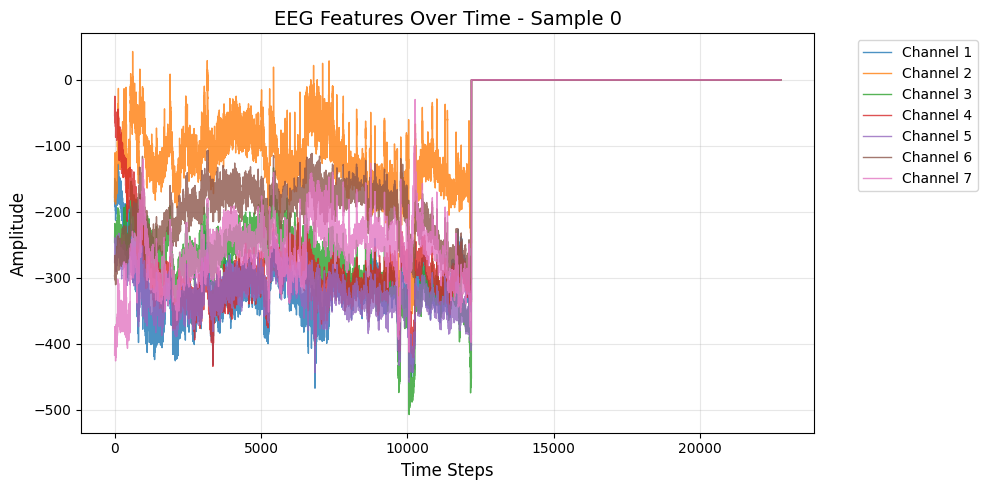

In [132]:
# Load the data as batched tensors
datas_tensor, labels_tensor = load_DSI_eeg_files_batched(r"D:\Programming\Python\Pytorch\Datasets\DSI")

# Split into train and validation sets
train_data, train_labels, val_data, val_labels = train_test_split_batched(datas_tensor, labels_tensor, test_size=0.2, shuffle=True)

plot_eeg_features(train_data, sample_idx=0, figsize=(10,5))

In [133]:
model = LSTM(input_features = train_data.shape[-1], hidden_features=100)

with torch.no_grad():
    outputs, (final_h, final_c) = model.forward(train_data)

In [134]:
epochs = 30
lr = 0.05
criterion = nn.MSELoss()
optimiser = torch.optim.Adamax(model.parameters(), lr=lr)

for epoch in range(epochs):
    optimiser.zero_grad()
    
    outputs, (hid_states, cell_states) = model.forward(train_data)
    
    labels = train_labels.squeeze(1)
    loss = criterion(outputs, labels)
    
    loss.backward()
    
    optimiser.step()
    
    if (epoch + 1) % 2 == 0:
        print(f"[Epoch] {epoch}, [Loss]:{loss}")

[Epoch] 1, [Loss]:0.4128130376338959
[Epoch] 3, [Loss]:0.09374164044857025
[Epoch] 5, [Loss]:0.06358708441257477
[Epoch] 7, [Loss]:0.049625612795352936
[Epoch] 9, [Loss]:0.04145091027021408
[Epoch] 11, [Loss]:0.033836930990219116
[Epoch] 13, [Loss]:0.03226644918322563
[Epoch] 15, [Loss]:0.02850860357284546
[Epoch] 17, [Loss]:0.026406079530715942
[Epoch] 19, [Loss]:0.02259306237101555
[Epoch] 21, [Loss]:0.021045176312327385
[Epoch] 23, [Loss]:0.020021682605147362
[Epoch] 25, [Loss]:0.018684010952711105
[Epoch] 27, [Loss]:0.01790359988808632
[Epoch] 29, [Loss]:0.01726626418530941


In [135]:
with torch.no_grad():
    val_predictions, (final_h, final_c) = model.forward(val_data)
    train_predictions, (t_final_h, t_final_c) = model.forward(train_data)
    
print(val_predictions.shape)
print(val_labels.shape)

torch.Size([3, 18039, 2])
torch.Size([3, 1, 18039, 2])


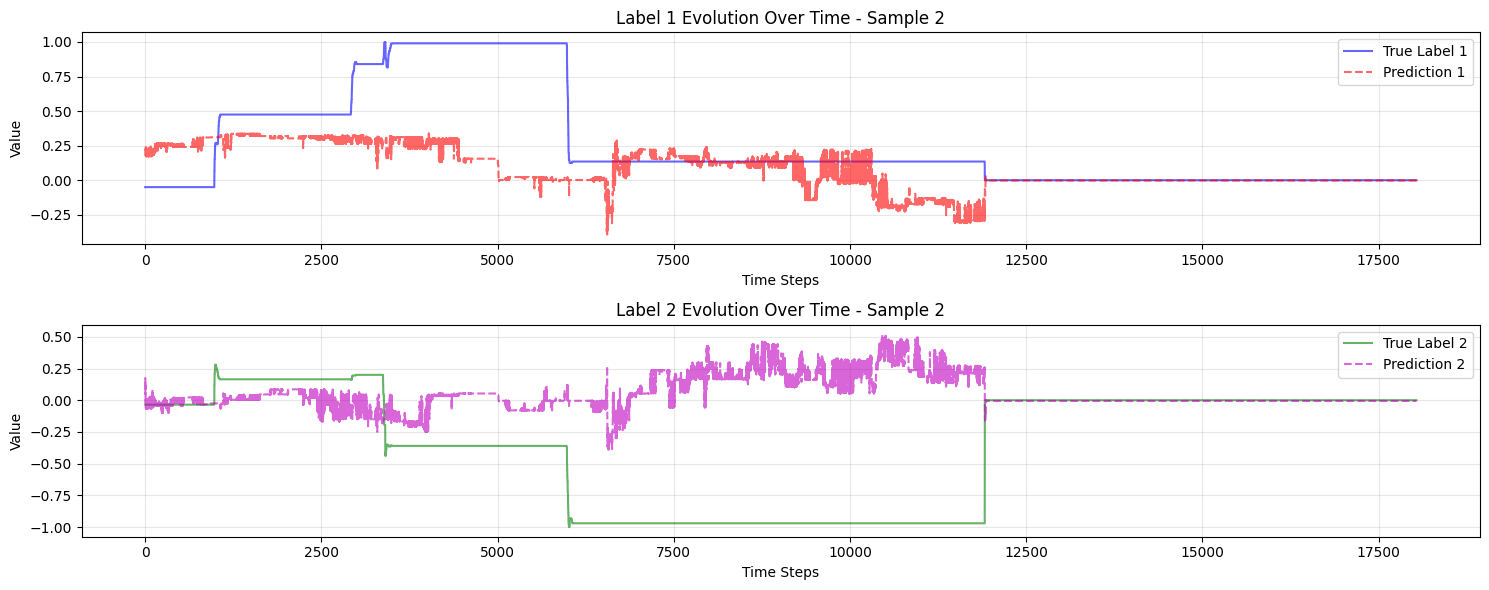

torch.Size([3, 18039, 2])
torch.Size([3, 1, 18039, 2])
R² scores across all samples:
Feature 1: -1.2830
Feature 2: -0.7586
Mean R²: -1.0208


In [139]:
def calculate_r2_scores(predictions, labels):
    """
    Calculate R² scores for each feature between predictions and labels.
    
    Args:
    predictions: tensor of shape (batch, timesteps, 2) or (batch, 1, timesteps, 2)
    labels: tensor of shape (batch, timesteps, 2) or (batch, 1, timesteps, 2)
    
    Returns:
    tuple: (r2_feature1, r2_feature2) R² scores for each feature
    """
    # Remove channel dimension if present
    if len(predictions.shape) == 4:
        predictions = predictions.squeeze(1)
    if len(labels.shape) == 4:
        labels = labels.squeeze(1)
    
    # Move to CPU and convert to numpy
    pred = predictions.detach().cpu().numpy()
    true = labels.detach().cpu().numpy()
    
    # Flatten batch dimension to get all timesteps for all samples
    pred_flat = pred.reshape(-1, 2)  # (batch * timesteps, 2)
    true_flat = true.reshape(-1, 2)  # (batch * timesteps, 2)
    
    # Calculate R² for each feature
    r2_scores = []
    for feature_idx in range(2):
        y_true = true_flat[:, feature_idx]
        y_pred = pred_flat[:, feature_idx]
        
        # Calculate mean of true values
        y_mean = np.mean(y_true)
        
        # Calculate total sum of squares
        ss_tot = np.sum((y_true - y_mean) ** 2)
        
        # Calculate residual sum of squares
        ss_res = np.sum((y_true - y_pred) ** 2)
        
        # Calculate R²
        r2 = 1 - (ss_res / ss_tot)
        r2_scores.append(r2)
    
    return tuple(r2_scores)

def print_r2_scores(predictions, labels, sample_idx=None):
    """
    Print R² scores with formatting. Can calculate for specific sample or all data.
    
    Args:
    predictions: tensor of shape (batch, timesteps, 2) or (batch, 1, timesteps, 2)
    labels: tensor of shape (batch, timesteps, 2) or (batch, 1, timesteps, 2)
    sample_idx: if provided, calculate R² for only this sample
    """
    if sample_idx is not None:
        # Calculate for specific sample
        r2_1, r2_2 = calculate_r2_scores(
            predictions[sample_idx:sample_idx+1], 
            labels[sample_idx:sample_idx+1]
        )
        print(f"R² scores for sample {sample_idx}:")
    else:
        # Calculate for all samples
        r2_1, r2_2 = calculate_r2_scores(predictions, labels)
        print("R² scores across all samples:")
    
    print(f"Feature 1: {r2_1:.4f}")
    print(f"Feature 2: {r2_2:.4f}")
    print(f"Mean R²: {((r2_1 + r2_2) / 2):.4f}")


# plot_predictions_vs_labels(train_predictions, train_labels, sample_idx=1)
plot_predictions_vs_labels(val_predictions, val_labels, sample_idx=2)
print(val_predictions.shape)
print(val_labels.shape)
print_r2_scores(val_predictions, val_labels)  # All samples
# print_r2_scores(val_predictions, val_labels, sample_idx=1)  # Specific sample
